In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# get the person and household files
hdf = pd.read_parquet('../../time-use-survey-2024/clean/hh-tus-2024.parquet')
pdf = pd.read_parquet('../../time-use-survey-2024/clean/per-tus-2024.parquet')

# Drop the activities with missing timeslots
pdf.dropna(subset=['time_from', 'time_to'], inplace=True)
pdf.head()

schedule_id  schedule  \
fsu_serial_no sample_hh_no person_serial_no                         
32223         1            1                        TUS       106   
                           1                        TUS       106   
                           1                        TUS       106   
                           1                        TUS       106   
                           1                        TUS       106   

                                             survey_year sector  nss_region  \
fsu_serial_no sample_hh_no person_serial_no                                   
32223         1            1                        2024  Rural          11   
                           1                        2024  Rural          11   
                           1                        2024  Rural          11   
                           1                        2024  Rural          11   
                           1                        2024  Rural          11   

                                             district  stratum  sub_stratum  \
fsu_serial_no sample_hh_no person_serial_no                                   
32223         1            1                       21       13            1   
                           1                       21       13            1   
                           1                       21       13            1   
                           1                       21       13            1   
                           1                       21       13            1   

                                             sub_round  fod_sub_region  ...  \
fsu_serial_no sample_hh_no person_serial_no                             ...   
32223         1            1                         2             110  ...   
                           1                         2             110  ...   
                           1                         2             110  ...   
                           1                         2             110  ...   
                           1                         2             110  ...   

                                            time_to  \
fsu_serial_no sample_hh_no person_serial_no           
32223         1            1                  07:00   
                           1                  07:30   
                           1                  08:00   
                           1                  09:30   
                           1                  12:00   

                                            performed_multiple_activities  \
fsu_serial_no sample_hh_no person_serial_no                                 
32223         1            1                                           no   
                           1                                           no   
                           1                                           no   
                           1                                           no   
                           1                                           no   

                                             performed_simultaneous_activities  \
fsu_serial_no sample_hh_no person_serial_no                                      
32223         1            1                                              None   
                           1                                              None   
                           1                                              None   
                           1                                              None   
                           1                                              None   

                                            major_minor_activity  \
fsu_serial_no sample_hh_no person_serial_no                        
32223         1            1                               major   
                           1                               major   
                           1                               major   
                           1                             

In [2]:
def get_time_spent(time_from, time_to):
    if time_from == time_to:
        return 24 * 60
    start_hour, start_min = map(int, time_from.split(':'))
    end_hour, end_min = map(int, time_to.split(':'))
    minutes = end_hour * 60 + end_min - start_hour * 60 - start_min
    if minutes > 0:
        return minutes
    return 24 * 60 + minutes

pdf['ts'] = pdf[['time_from', 'time_to']].apply(lambda x: get_time_spent(**x), axis=1)
pdf['ACT_CODE'] = pdf['activity_code'].astype(str).str.get(0).astype(int)

# Person-level multiplier
MULT = pdf['mult'].reset_index().drop_duplicates().set_index(pdf.index.names, verify_integrity=True)['mult']

In [3]:
# demographics, personal info
meta = pdf.groupby(pdf.index, group_keys=False)[['gender', 'age', 'marital_status', 'education']].take([0])

In [4]:
# Add a column to determine who has worked at all
working = pdf.groupby(pdf.index)['ACT_CODE'].apply(lambda x: x.min() == 1)
working.index = pd.MultiIndex.from_tuples(working.index, names=meta.index.names)
meta['working'] = working

In [5]:
def ts_working(group):
    df = group[group['ACT_CODE'] == 1]
    return df.drop_duplicates(subset=['time_from', 'time_to'])['ts'].sum()

# Get time spent in working, for those who did
ts_work = pdf.groupby(pdf.index)[['ACT_CODE', 'ts', 'time_from', 'time_to']].apply(ts_working)
ts_work.index = pd.MultiIndex.from_tuples(ts_work.index, names=meta.index.names)
meta['ts_work'] = ts_work

In [6]:
meta.head()

gender  age     marital_status  \
fsu_serial_no sample_hh_no person_serial_no                                   
30010         1            1                   male   45      never married   
              2            1                   male   54  currently married   
                           2                 female   52  currently married   
                           3                 female   29  currently married   
              3            1                   male   48  currently married   

                                                        education  working  \
fsu_serial_no sample_hh_no person_serial_no                                  
30010         1            1                             graduate     True   
              2            1                     higher secondary    False   
                           2                 upper primary/middle    False   
                           3                             graduate     True   
              3            1                            secondary     True   

                                             ts_work  
fsu_serial_no sample_hh_no person_serial_no           
30010         1            1                     300  
              2            1                       0  
                           2                       0  
                           3                     480  
              3            1                     480

In [7]:
cols = ['sector', 'religion', 'social_group', 'total_monthly_ce']

# Get these columns from the household dataset
meta.reset_index(level=-1, inplace=True)
df = hdf[cols].merge(meta, how='outer', left_index=True, right_index=True).reset_index().set_index(['fsu_serial_no', 'sample_hh_no', 'person_serial_no'], verify_integrity=True)
df.head()

sector  religion  \
fsu_serial_no sample_hh_no person_serial_no                    
30010         1            1.0               Rural  Hinduism   
              2            1.0               Rural  Hinduism   
                           2.0               Rural  Hinduism   
                           3.0               Rural  Hinduism   
              3            1.0               Rural  Hinduism   

                                                     social_group  \
fsu_serial_no sample_hh_no person_serial_no                         
30010         1            1.0               other backward class   
              2            1.0               other backward class   
                           2.0               other backward class   
                           3.0               other backward class   
              3            1.0               other backward class   

                                             total_monthly_ce  gender   age  \
fsu_serial_no sample_hh_no person_serial_no                                   
30010         1            1.0                         7142.0    male  45.0   
              2            1.0                        18317.0    male  54.0   
                           2.0                        18317.0  female  52.0   
                           3.0                        18317.0  female  29.0   
              3            1.0                        10147.0    male  48.0   

                                                marital_status  \
fsu_serial_no sample_hh_no person_serial_no                      
30010         1            1.0                   never married   
              2            1.0               currently married   
                           2.0               currently married   
                           3.0               currently married   
              3            1.0               currently married   

                                                        education working  \
fsu_serial_no sample_hh_no person_serial_no                                 
30010         1            1.0                           graduate    True   
              2            1.0                   higher secondary   False   
                           2.0               upper primary/middle   False   
                           3.0                           graduate    True   
              3            1.0                          secondary    True   

                                             ts_work  
fsu_serial_no sample_hh_no person_serial_no           
30010         1            1.0                 300.0  
              2            1.0                   0.0  
                           2.0                   0.0  
                           3.0                 480.0  
              3            1.0                 480.0

In [8]:
# Add back the multiplier
df['mult'] = MULT
df.dropna(inplace=True)

In [9]:
# get the workforce
workforce = df[df['working']]
workforce = workforce[workforce['age'] >= 15]
workforce = workforce[workforce['age'] <= 60]
workforce.head()

sector  religion  \
fsu_serial_no sample_hh_no person_serial_no                    
30010         1            1.0               Rural  Hinduism   
              2            3.0               Rural  Hinduism   
              3            1.0               Rural  Hinduism   
                           2.0               Rural  Hinduism   
              4            1.0               Rural  Hinduism   

                                                     social_group  \
fsu_serial_no sample_hh_no person_serial_no                         
30010         1            1.0               other backward class   
              2            3.0               other backward class   
              3            1.0               other backward class   
                           2.0               other backward class   
              4            1.0               other backward class   

                                             total_monthly_ce  gender   age  \
fsu_serial_no sample_hh_no person_serial_no                                   
30010         1            1.0                         7142.0    male  45.0   
              2            3.0                        18317.0  female  29.0   
              3            1.0                        10147.0    male  48.0   
                           2.0                        10147.0  female  44.0   
              4            1.0                        13387.0    male  38.0   

                                                marital_status      education  \
fsu_serial_no sample_hh_no person_serial_no                                     
30010         1            1.0                   never married       graduate   
              2            3.0               currently married       graduate   
              3            1.0               currently married      secondary   
                           2.0               currently married  below primary   
              4            1.0               currently married        primary   

                                            working  ts_work      mult  
fsu_serial_no sample_hh_no person_serial_no                             
30010         1            1.0                 True    300.0  208857.0  
              2            3.0                 True    480.0  208857.0  
              3            1.0                 True    480.0  208857.0  
                           2.0                 True     30.0  208857.0  
              4            1.0                 True    570.0  208857.0

In [10]:
# Get the Monthly CE quartile
workforce['MCE_qrt'] = pd.qcut(workforce['total_monthly_ce'], 4, labels=["1st", "2nd", "3rd", "4th"])

In [11]:
CAT_COLS = ['sector', 'social_group', 'gender', 'marital_status', 'education', 'MCE_qrt', 'age']
SERIES = {}

for c in CAT_COLS:
    t = workforce.groupby(c).apply(lambda x: (x['ts_work'] * x['mult']).sum() / x['mult'].sum())
    t = t / 60 * 7
    SERIES[c] = t.sort_values()

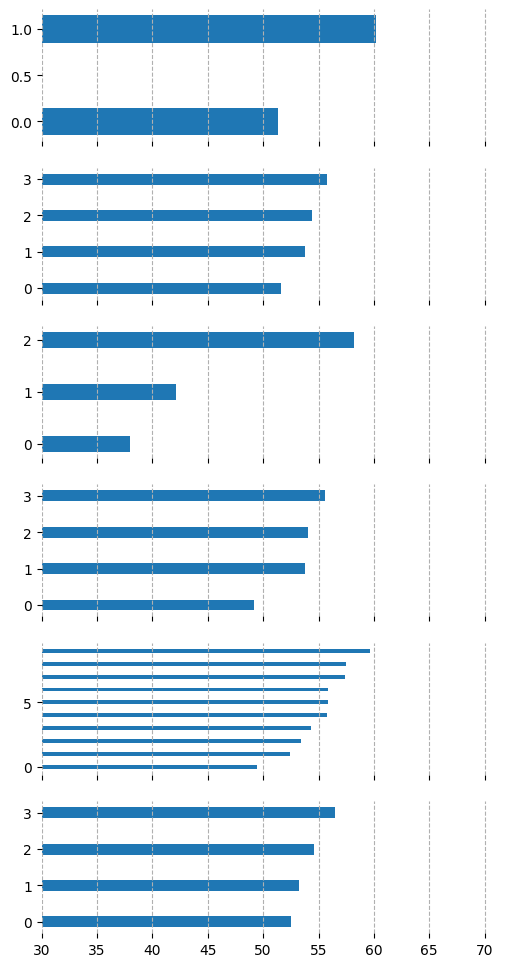

In [59]:
fig, ax = plt.subplots(nrows=len(CAT_COLS) - 1, ncols=1, sharex=True, figsize=(6, 12))

for i, (ax_, col) in enumerate(zip(ax.ravel(), CAT_COLS)):
    if col == 'age':
        continue
    ax_.barh(range(len(SERIES[col])), SERIES[col].values, height=0.3)
    
    ax_.set_xlim(30, 72)
    ax_.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax_.grid(axis='x', linestyle='dashed')